In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
import torch.nn.functional as F

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf",
                                                          torch_dtype=torch.float16,
                                                          low_cpu_mem_usage=True).to("cuda:0")

/home/hasan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


In [2]:
self = model

In [3]:
random_response = requests.get("https://source.unsplash.com/random/400x400?sig=1")
file = open('image.jpg', 'wb')
file.write(random_response.content)
file.close()

In [4]:
image = Image.open('image.jpg')

In [5]:
prompts = "[INST] <image>\nWhat is shown in this image? [/INST]"
inputs = processor(prompts, image, return_tensors="pt").to("cuda:0")
image_num_patches = [5]

In [6]:
# prompts = [
#     "[INST] <image>\nWhat is shown in this image? [/INST]",
#     "[INST] <image>\nWhat is shown in this image? [/INST]",
# ]
# inputs = processor(prompts, [image,image], return_tensors="pt").to("cuda:0")
# image_num_patches = [5,5]

In [7]:
pixel_values = inputs.pixel_values
_pixel_values_list = [pix_val[:num_patch] for pix_val, num_patch in zip(pixel_values, image_num_patches)]
pixel_values = torch.cat(_pixel_values_list, dim=0)

In [8]:
image_features = model.vision_tower(pixel_values, output_hidden_states=True,output_attentions=True)
clip_attention_scores = image_features.attentions
selected_image_feature = image_features.hidden_states[-2]
image_features = self.multi_modal_projector(selected_image_feature)
print(image_features.shape)

torch.Size([5, 577, 4096])


In [9]:
image_features = torch.split(image_features, image_num_patches, dim=0) # (torch.Size([n, 576, 4096])],...)

In [10]:
def get_attention_scores(
    clip_attention_scores: torch.Tensor,
    layers_in_use=[0,22],
    image_num_patches=[5],
    ):

        clip_attention_scores_tensor = torch.stack([clip_attention_scores[layer] for layer in layers_in_use], dim=1)
        clip_attention_scores = torch.split(clip_attention_scores_tensor, image_num_patches, dim=0)
        return clip_attention_scores


In [11]:
clip_attention_scores = get_attention_scores(clip_attention_scores, layers_in_use=range(24), image_num_patches=image_num_patches)

In [12]:
# print all shapes
print(f"""
    image_features: {type(image_features)}, {len(image_features)}, {image_features[0].shape}
    clip_attention_scores: {type(clip_attention_scores)}, {len(clip_attention_scores)}, {clip_attention_scores[0].shape}
    """)


    image_features: <class 'tuple'>, 1, torch.Size([5, 577, 4096])
    clip_attention_scores: <class 'tuple'>, 1, torch.Size([5, 24, 16, 577, 577])
    


In [13]:
import torch
import matplotlib.pyplot as plt

def plot_attention_scores_for_all_layers(attention_scores, batch_id, num_features=576):
    attention_scores = attention_scores[batch_id]  # [num_patches, num_layers, num_heads, num_tokens, num_tokens]
    attention_scores = attention_scores[:, :, :, 0, -num_features:]  # [num_patches, num_layers, num_heads, num_tokens]
    attention_scores = attention_scores.mean(dim=2)  # [num_patches, num_layers, num_tokens]
    attention_scores = attention_scores[0]  # [num_layers, num_tokens] for the first patch only

    num_layers = attention_scores.shape[0]
    
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, 2*num_layers))
    
    for layer in range(num_layers):
        layer_attention = attention_scores[layer]  # [num_tokens]

        axes[layer].bar(range(layer_attention.shape[0]), layer_attention.detach().cpu().numpy())
        axes[layer].set_title(f'Layer {layer + 1} Attention Scores')
        axes[layer].set_xlabel('Token')
        axes[layer].set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming attention_scores is a tensor of shape [batch_size, num_patches, num_layers, num_heads, num_tokens, num_tokens]
# attention_scores = torch.randn(batch_size, num_patches, num_layers, num_heads, num_tokens, num_tokens)
# plot_attention_scores_for_all_layers(attention_scores, batch_id=0)

In [14]:
def plot_attention_scores_layerswise(attention_scores, batch_id, layer_id, num_features=576):
    import matplotlib.pyplot as plt
    import numpy as np

    attention_scores = attention_scores[batch_id] # [num_patches, num_layers, num_heads, num_tokens, num_tokens]
    attention_scores = attention_scores[:, :, :, 0, -num_features:] # [num_patches, num_layers, num_heads, num_tokens]
    attention_scores = attention_scores.mean(dim=2) # [num_patches, num_layers, num_tokens]
    attention_scores = attention_scores[:, layer_id, :]
    attention_scores = attention_scores.cpu().detach().numpy()

    num_token_patches = attention_scores.shape[1]
    num_token_grid = int(np.sqrt(num_token_patches))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    whole_image_attention = attention_scores[0].reshape(num_token_grid, num_token_grid)
    axes[0].imshow(whole_image_attention, cmap='viridis')
    axes[0].set_title('Whole Image Attention')
    axes[0].axis('off')

    patches_attention = attention_scores[1:]
    grid_size = int(np.sqrt(patches_attention.shape[0]))

    combined_patches_attention = np.block([
        [patches_attention[i * grid_size + j].reshape(num_token_grid, num_token_grid) for j in range(grid_size)]
        for i in range(grid_size)
    ])
    axes[1].imshow(combined_patches_attention, cmap='viridis')
    axes[1].set_title('Patches Attention')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_attention_distribution_for_all_layers(attention_scores, batch_id, num_features=576):
    attention_scores = attention_scores[batch_id]  # [num_patches, num_layers, num_heads, num_tokens, num_tokens]
    attention_scores = attention_scores[:, :, :, 0, -num_features:]  # [num_patches, num_layers, num_heads, num_tokens]
    attention_scores = attention_scores.mean(dim=2)  # [num_patches, num_layers, num_tokens]
    attention_scores = attention_scores[0]  # [num_layers, num_tokens] for the first patch only

    num_layers = attention_scores.shape[0]
    
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, 2*num_layers))
    
    for layer in range(num_layers):
        layer_attention = attention_scores[layer]  # [num_tokens]
        layer_attention = F.softmax(layer_attention, dim=-1)  # Convert scores to probabilities

        axes[layer].bar(range(layer_attention.shape[0]), layer_attention.detach().cpu().numpy())
        axes[layer].set_title(f'Layer {layer + 1} Attention Distribution')
        axes[layer].set_xlabel('Token')
        axes[layer].set_ylabel('Probability')
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming attention_scores is a tensor of shape [batch_size, num_patches, num_layers, num_heads, num_tokens, num_tokens]
# attention_scores = torch.randn(batch_size, num_patches, num_layers, num_heads, num_tokens, num_tokens)
# plot_attention_distribution_for_all_layers(attention_scores, batch_id=0)

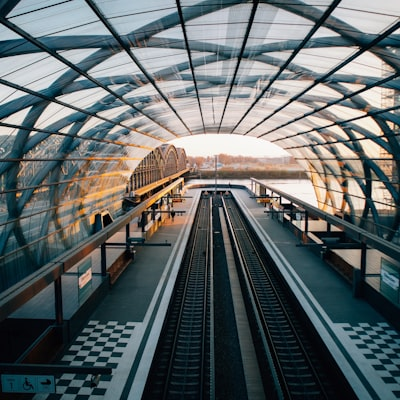

In [16]:
image.show()

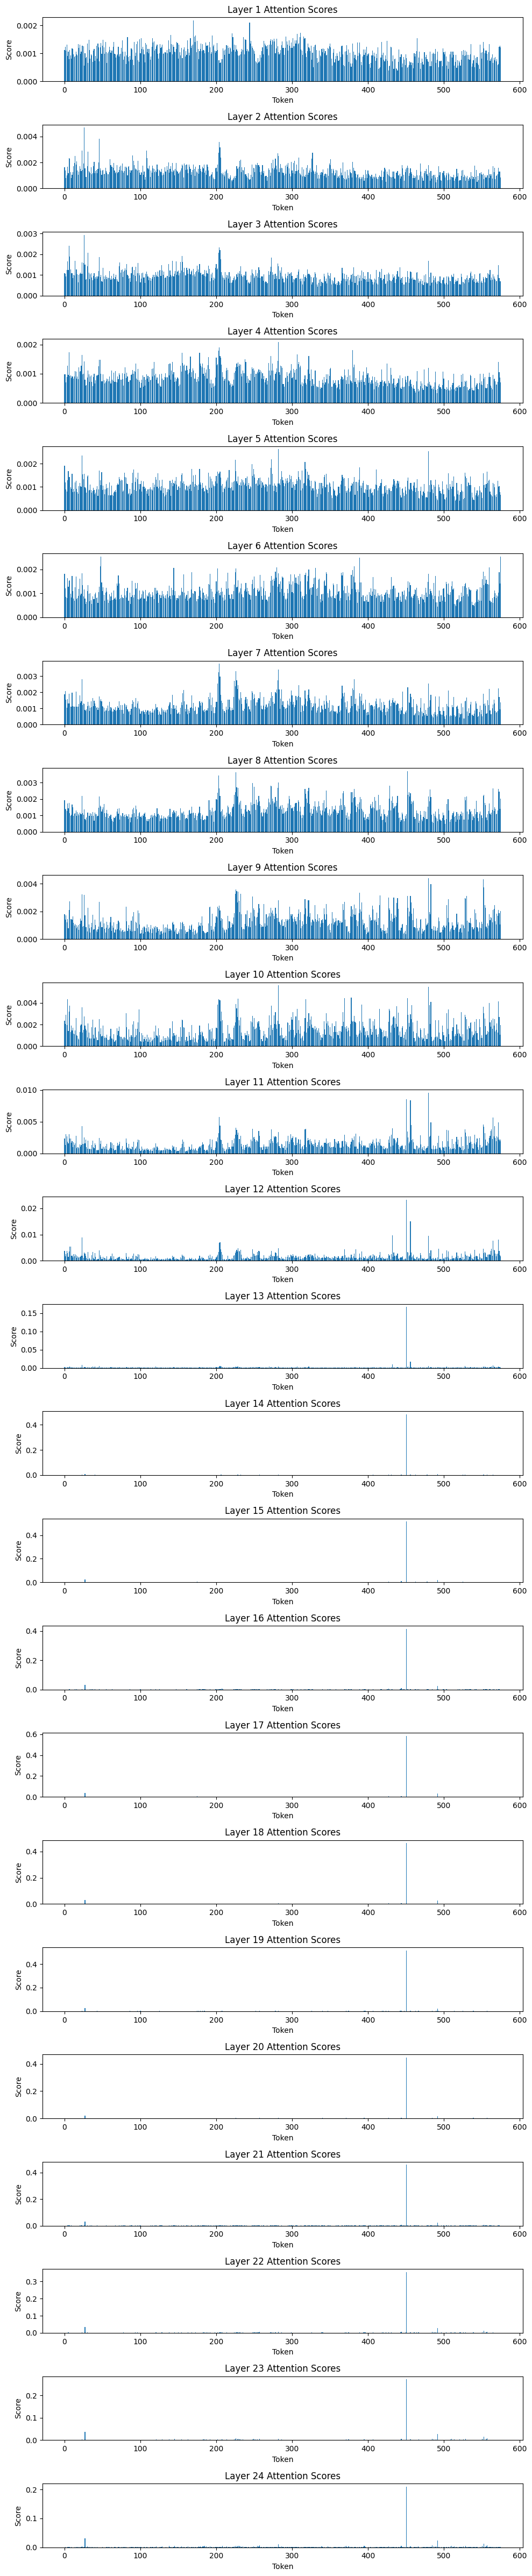

In [17]:
plot_attention_scores_for_all_layers(clip_attention_scores, batch_id=0)